Finish initialization...
Finish initialization...
Successfully load the DVI visualization model for iteration 200
Computing decision regions ...
Successfully load the DVI visualization model for iteration 200
Successfully load the DVI visualization model for iteration 200


100%|██████████| 250/250 [00:00<00:00, 7321.74it/s]


Successfully load the DVI visualization model for iteration 200


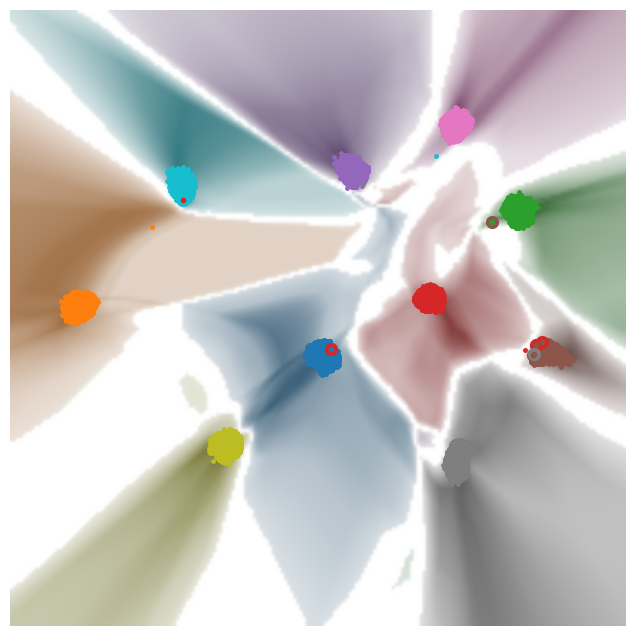

In [3]:
########################################################################################################################
#                                                          IMPORT                                                      #
########################################################################################################################
import torch
import sys
import os
import json
import time
import numpy as np
import argparse
sys.path.append("/home/yifan/projects/cophi/ContraVis")

from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params
from contrast.transfomration import *

from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import UmapLoss, ReconstructionLoss, TemporalLoss, DVILoss, SingleVisLoss, DummyTemporalLoss
from singleVis.edge_dataset import DVIDataHandler
from singleVis.trainer import DVITrainer
from singleVis.data import NormalDataProvider
# from singleVis.spatial_edge_constructor import SingleEpochSpatialEdgeConstructor
from singleVis.spatial_edge_constructor import SpitalEdgeForContrastConstructor

from singleVis.projector import DVIProjector,ContraProjector
from singleVis.utils import find_neighbor_preserving_rate

########################################################################################################################
#                                                      PARAMETERS                                                   #
########################################################################################################################
"""This serve as an example of DeepVisualInsight implementation in pytorch."""
VIS_METHOD = "DVI" # DeepVisualInsight


TAR_PATH = "/home/yifan/dataset/resnet18_with_dropout/pairflip/cifar10/0"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"

########################################################################################################################
#                                                     LOAD PARAMETERS                                                  #
########################################################################################################################


CONTENT_PATH = REF_PATH
sys.path.append(CONTENT_PATH)
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    config = json.load(f)
config = config[VIS_METHOD]

# record output information
# now = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time())) 
# sys.stdout = open(os.path.join(CONTENT_PATH, now+".txt"), "w")

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
PREPROCESS = config["VISUALIZATION"]["PREPROCESS"]
GPU_ID = config["GPU"]
GPU_ID = 1
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

EPOCH_START = 200
EPOCH_END = 200
EPOCH_PERIOD = 1

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
LAMBDA1 = VISUALIZATION_PARAMETER["LAMBDA1"]
LAMBDA2 = VISUALIZATION_PARAMETER["LAMBDA2"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]


S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = 'Contravis' ### saved_as 
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

# Define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))

########################################################################################################################
#                                                    TRAINING SETTING                                                  #
########################################################################################################################
# Define data_provider
#TODO
TAE_NET = "resnet18_with_dropout"
tar_net = eval("subject_model.{}()".format(TAE_NET)) 

data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, epoch_name='Epoch',classes=CLASSES,verbose=1)
tar_data_provider = NormalDataProvider(TAR_PATH, tar_net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, epoch_name='Epoch',classes=CLASSES,verbose=1)


# Define visualization models
model = VisModel(ENCODER_DIMS, DECODER_DIMS)


# Define Losses
negative_sample_rate = 5
min_dist = .1
_a, _b = find_ab_params(1.0, min_dist)
umap_loss_fn = UmapLoss(negative_sample_rate, DEVICE, _a, _b, repulsion_strength=1.0)
recon_loss_fn = ReconstructionLoss(beta=1.0)
single_loss_fn = SingleVisLoss(umap_loss_fn, recon_loss_fn, lambd=LAMBDA1)
# Define Projector
projector = ContraProjector(vis_model=model, content_path='./Contravis.pth', vis_model_name=VIS_MODEL_NAME, device=DEVICE)
    

########################################################################################################################
#                                                      VISUALIZATION                                                   #
########################################################################################################################

from singleVis.visualizer import visualizer
now = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time())) 
vis = visualizer(data_provider, projector, 200, "tab10")
save_dir = os.path.join(data_provider.content_path, "contraImg")
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

vis.savefig(EPOCH_START, path="./ref.png")

Successfully load the DVI visualization model for iteration 200
Computing decision regions ...
Successfully load the DVI visualization model for iteration 200
Successfully load the DVI visualization model for iteration 200


100%|██████████| 250/250 [00:00<00:00, 3852.30it/s]


Successfully load the DVI visualization model for iteration 200


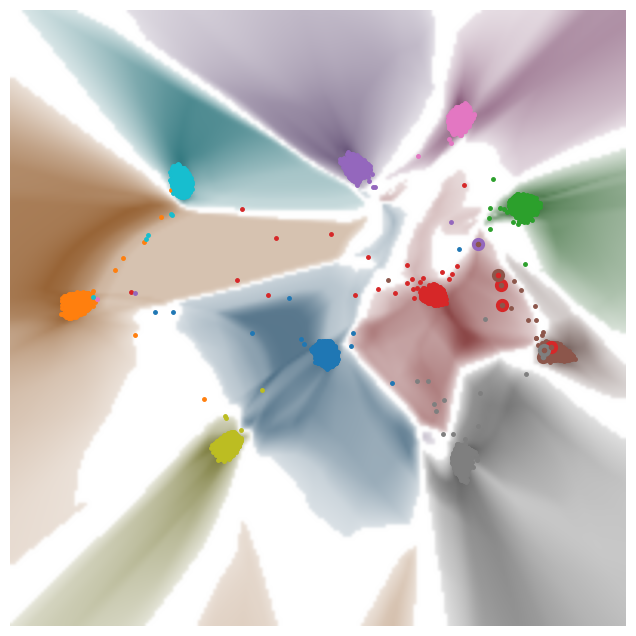

In [4]:

from singleVis.visualizer_for_tar import visualizer

transed_model = torch.load('./trans_model.m').to(DEVICE)
now = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time())) 
vis = visualizer(data_provider, tar_data_provider, transed_model, projector, 200,DEVICE, "tab10")
save_dir = os.path.join(data_provider.content_path, "contraImg")
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
for i in range(EPOCH_START, EPOCH_END+1, EPOCH_PERIOD):
    vis.savefig(i, path= "./tar.png")